In [1]:
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os
import SimpleITK as sitk

# Personal library
import prepare_data
import simulation 

Global seed 0
Global seed 0


### Load Example Image

In [2]:
test_load = sitk.GetArrayFromImage(sitk.ReadImage('images/TRACE-VCI-DOWNSIZED/TRACEVCI_20018_WMHinMNImasked.nii.gz'))
roi_load = sitk.GetArrayFromImage(sitk.ReadImage('images/roi_image_0.nii.gz'))
print(test_load.shape)
print(roi_load.shape)

(152, 179, 142)
(152, 179, 142)


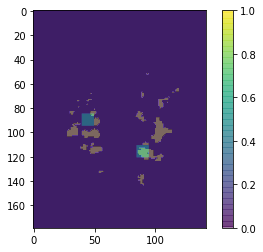

In [3]:
# quick visualization check
raw_image = test_load[105, :, :]
roi_image = roi_load[105, :, :]

roi_alpha = 0.5 
roi_image_with_alpha = roi_image * roi_alpha
plt.imshow(raw_image, cmap='tab20b', vmin=0, vmax=3)
plt.imshow(roi_image_with_alpha, cmap='viridis', vmin=0, vmax=1, alpha=0.5)

plt.colorbar() 
plt.show()

# Load TRACE-VCI 3D

In [2]:
# Define data paths
dir_lesion_path = glob.glob('images/TRACE-VCI/TRACEVCI*.gz') # 3D Image directory
dir_downsized_path = 'images/TRACE-VCI-DOWNSIZED/' # 3D cropped image directory
pt_ids = len(dir_lesion_path)

mni_cor = [2, 154, 21, 200, 19, 161] # Voxels containing only brain tissue in MNI-space

# Crop images -> Uncomment in first run
# prepare_data.downsize_data(dir_lesion_path, dir_downsized_path, mni_coordinates=mni_cor)

In [3]:
# Set simulation parameters
roi_weights = [1,1,1]
roi_size = 5 # Diameter of a single ROI dimension [mm]
roi_threshold = 10
roi_origins = [[94, 112, 94], [106, 90, 45], [105, 116, 90]]

# Get ROI, lesion matrix and patients ids
roi_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join('images/','roi_image_0.nii.gz')))
patient_ids = prepare_data.get_ids(dir_downsized_path)
lesion_matrix = prepare_data.lesion_matrix(patient_ids, dir_downsized_path) # Lesion matrix is ordered the same as included_pts
# lesion_matrix, mask_indices, prevalence_mask = prepare_data.pt_threshold(lesion_matrix, threshold=10)

  0%|          | 0/821 [00:00<?, ?it/s]

Creating a lesion matrix with the following dimensions: (821, 152, 179, 142)


  0%|          | 0/821 [00:00<?, ?it/s]

In [5]:
#Get ROI images
simulation.get_rois(lesion_matrix, roi_threshold, roi_size, None)

/user/ana/S_Source/Simulation3D/images/lesion_mask.nii.gz
Saved lesion mask image
ROI origins: [94, 112, 94], [106, 90, 45], [105, 116, 90]
Saved ROI image
Saved ROI image
Saved ROI image
Saved ROI image


([[94, 112, 94], [106, 90, 45], [105, 116, 90]],
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 

Patient  20004


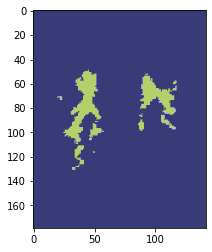

In [5]:
# Quick visualiztion check
print('Patient ', patient_ids[1])
plt.imshow(lesion_matrix[1, 105, :, :], cmap='tab20b', vmin=0, vmax=3)
plt.show()

# Proof of concept

In [5]:
# Determine Proof-of-concept artificial cognitive scores
scores_oo, scores_mo, _ = simulation.get_scores(lesion_matrix, roi_origins, roi_threshold, roi_weights, roi_size)

print('One-output scores:', scores_oo.shape)
print('Multi-output scores:', scores_mo.shape)

One-output scores: (1, 821)
Multi-output scores: (821, 3)


In [6]:
### Save data into local files
# one-output
doo = {'Patient': patient_ids, 'Score': scores_oo[0,:]}
df_oo = pd.DataFrame(data = doo)
oo_results_path = 'experiments/one_output_3D'
#simulation.save_simulation_data(df_oo, lesion_matrix, roi_origins, oo_results_path)

# multi-output
dmo = {'Patient': patient_ids, 'Score 1': scores_mo[:,0], 'Score 2': scores_mo[:,1],'Score 3': scores_mo[:,2]}
df_mo = pd.DataFrame(data = dmo)
mo_results_path = 'experiments/multi_output_3D'
#simulation.save_simulation_data(df_mo, lesion_matrix, roi_origins, mo_results_path)

### Visualize

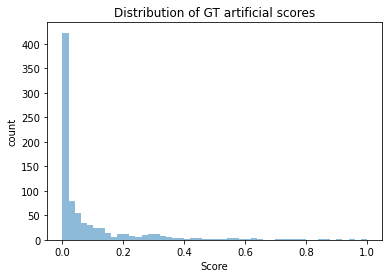

In [7]:
# HISTOGRAM
data = list(df_oo['Score'])
# fixed bin size
bins = 50  # fixed bin size
plt.hist(data, bins=bins, alpha=0.5)
plt.title('Distribution of GT artificial scores')
plt.xlabel('Score')
plt.ylabel('count')
plt.show()

In [13]:
count = (df_oo['Score'] == 1).sum()
print(count, 'patients have a score of 1')

count = (df_oo['Score'] == 0).sum()
print(count, 'patients have a score of 0')

count = (df_oo['Score'] < 0).sum()
print(count, 'patients have negative scores')

1 patients have a score of 1
170 patients have a score of 0
0 patients have negative scores


Text(0, 0.5, 'Count')

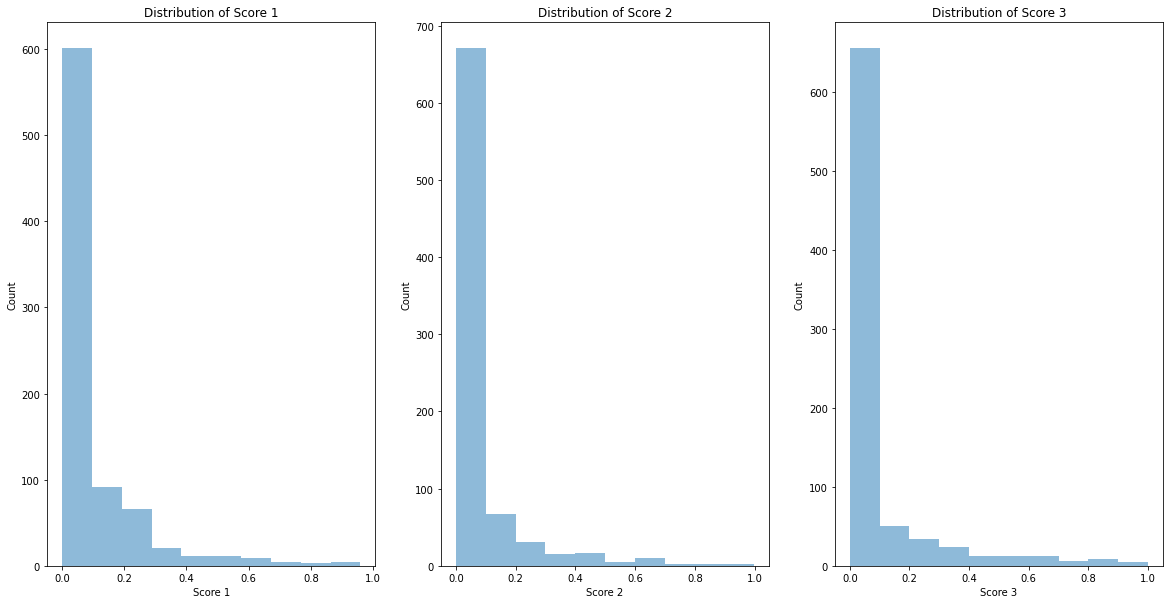

In [14]:
# Multi-output
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Separate the sublists into two lists
s1 = list(df_mo['Score 1'])
s2 = list(df_mo['Score 2'])
s3 = list(df_mo['Score 3'])

# Plot the first histogram in the top-left position
axs[0].hist(s1, alpha=0.5)
axs[0].set_title('Distribution of Score 1')
axs[0].set_xlabel('Score 1')
axs[0].set_ylabel('Count')

# Plot the second histogram in the top-right position
axs[1].hist(s2, alpha=0.5)
axs[1].set_title('Distribution of Score 2')
axs[1].set_xlabel('Score 2')
axs[1].set_ylabel('Count')

# Plot the second histogram in the top-right position
axs[2].hist(s3, alpha=0.5)
axs[2].set_title('Distribution of Score 3')
axs[2].set_xlabel('Score 3')
axs[2].set_ylabel('Count')

# Noise Experiment

In [8]:
# Determine Noise artificial cognition scores
noise_strength = 0.5 # Change eery time to the noise weight you want to obtain 0.4,0.3,0.2,0.1
noise = "gaussian"
noisy_scores_oo, noisy_scores_mo, _ = simulation.get_scores(lesion_matrix, roi_origins, roi_threshold, roi_weights, roi_size, noise=True, error_weight=noise_strength, noise_type=noise)

print('One-output scores:',noisy_scores_oo.shape)
print('Multi-output scores:',noisy_scores_mo.shape)

One-output scores: (1, 821)
Multi-output scores: (821, 3)


In [9]:
# Normalize scores to be in range 0 (no lesion) 1 (lesion)
noisy_scores_oo_norm = simulation.normalize_oo_noisy_scores(noisy_scores_oo)
noisy_scores_mo_norm = simulation.normalize_mo_noisy_scores(noisy_scores_mo)

In [10]:
### Save data into local files
# one-output
doo = {'Patient': patient_ids, 'Score': noisy_scores_oo[0,:]}
df_oo = pd.DataFrame(data = doo)
oo_results_path = os.path.join("experiments/one_output_3D/noise/"+ noise + "/" + str(noise_strength))
# simulation.save_simulation_data(df_oo, lesion_matrix, roi_origins, oo_results_path, False, True)

In [11]:
# multi-output
dmo = {'Patient': patient_ids, 'Score 1': noisy_scores_mo[:,0], 'Score 2': noisy_scores_mo[:,1], 'Score 3': noisy_scores_mo[:,2]}
df_mo = pd.DataFrame(data = dmo)
mo_results_path =  os.path.join("experiments/multi_output_3D/noise/"+ noise + "/" + str(noise_strength))
# simulation.save_simulation_data(df_mo, lesion_matrix, roi_origins, mo_results_path, False, True)

In [12]:
### Save norm data into local files
# one-output
doo_n = {'Patient': patient_ids, 'Score': noisy_scores_oo_norm[0,:]}
df_oo_n = pd.DataFrame(data = doo_n)
df_oo_n.to_pickle(os.path.join(oo_results_path, "ds_simulation_scores_norm.pkl"))
# multi-output
dmo_n = {'Patient': patient_ids, 'Score 1': noisy_scores_mo_norm[:,0], 'Score 2': noisy_scores_mo_norm[:,1], 'Score 3': noisy_scores_mo_norm[:,2]}
df_mo_n = pd.DataFrame(data = dmo_n)
df_mo_n.to_pickle(os.path.join(mo_results_path, "ds_simulation_scores_norm.pkl"))

### Visualize

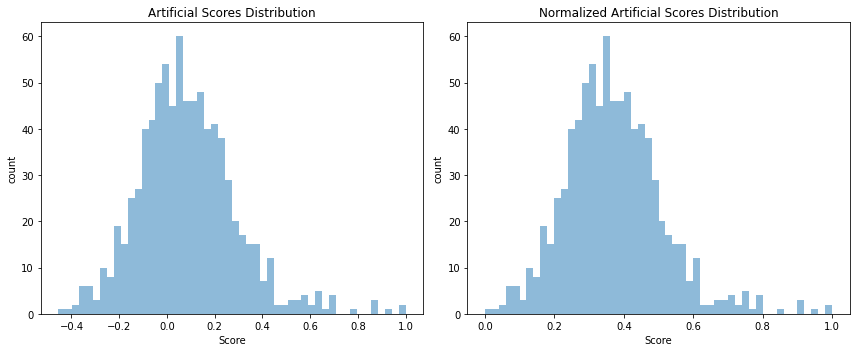

In [13]:
# Histogram for one_score
data = list(doo['Score'])
data2 = list(doo_n['Score'])

bins = 50
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.hist(data, bins=bins, alpha=0.5)
plt.title('Artificial Scores Distribution')
plt.xlabel('Score')
plt.ylabel('count')

# Histogram for multi_score (first column)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.hist(data2, bins=bins, alpha=0.5)
plt.title('Normalized Artificial Scores Distribution')
plt.xlabel('Score')
plt.ylabel('count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

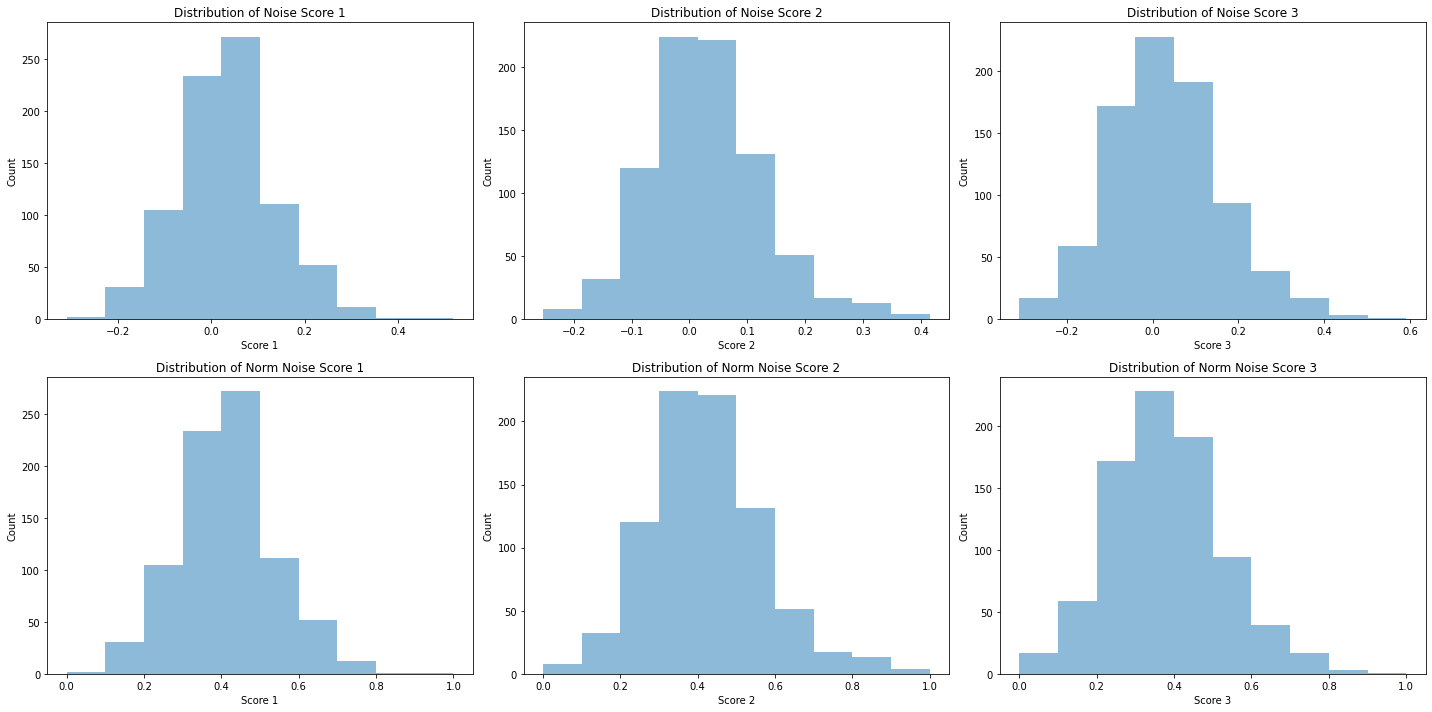

In [51]:
# Create subplots with 2 rows and 3 columns
fig1, axs = plt.subplots(2, 3, figsize=(20, 10))

# Separate the sublists into two lists
s1 = list(df_mo['Score 1'])
s2 = list(df_mo['Score 2'])
s3 = list(df_mo['Score 3'])

s1_norm = list(df_mo_n['Score 1'])
s2_norm = list(df_mo_n['Score 2'])
s3_norm = list(df_mo_n['Score 3'])

# Plot the first histogram in the top-left position
axs[0, 0].hist(s1, alpha=0.5)
axs[0, 0].set_title('Distribution of Noise Score 1')
axs[0, 0].set_xlabel('Score 1')
axs[0, 0].set_ylabel('Count')

# Plot the second histogram in the top-right position
axs[0, 1].hist(s2, alpha=0.5)
axs[0, 1].set_title('Distribution of Noise Score 2')
axs[0, 1].set_xlabel('Score 2')
axs[0, 1].set_ylabel('Count')

# Plot the second histogram in the top-right position
axs[0, 2].hist(s3, alpha=0.5)
axs[0, 2].set_title('Distribution of Noise Score 3')
axs[0, 2].set_xlabel('Score 3')
axs[0, 2].set_ylabel('Count')

# Plot the third histogram in the bottom-left position
axs[1, 0].hist(s1_norm, alpha=0.5)
axs[1, 0].set_title('Distribution of Norm Noise Score 1')
axs[1, 0].set_xlabel('Score 1')
axs[1, 0].set_ylabel('Count')

# Plot the fourth histogram in the bottom-right position
axs[1, 1].hist(s2_norm, alpha=0.5)
axs[1, 1].set_title('Distribution of Norm Noise Score 2')
axs[1, 1].set_xlabel('Score 2')
axs[1, 1].set_ylabel('Count')

# Plot the fourth histogram in the bottom-right position
axs[1, 2].hist(s3_norm, alpha=0.5)
axs[1, 2].set_title('Distribution of Norm Noise Score 3')
axs[1, 2].set_xlabel('Score 3')
axs[1, 2].set_ylabel('Count')
# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


# Intercorrelation experiment

In [11]:
# Dependency of a weight on main ROI
weight = 0.9 # change for different dataset simulations: 0.8,0.7,0.6
_, _, scores_ic = simulation.get_scores(lesion_matrix, roi_origins, roi_threshold, roi_weights, roi_size, a=weight, b=weight)

print('Multi-output scores:', scores_ic.shape)

Multi-output scores: (821, 3)


In [12]:
# intercorrelated multi-output
dmoic = {'Patient': patient_ids, 'Score 1': scores_ic[:,0], 'Score 2': scores_ic[:,1],'Score 3': scores_ic[:,2]}
df_mo_ic = pd.DataFrame(data = dmoic)
mo_ic_results_path = os.path.join("experiments/ic_multi_output_3D/scores/"+ str(weight))

simulation.save_simulation_data(df_mo_ic, lesion_matrix, roi_origins, mo_ic_results_path)

Text(0, 0.5, 'Count')

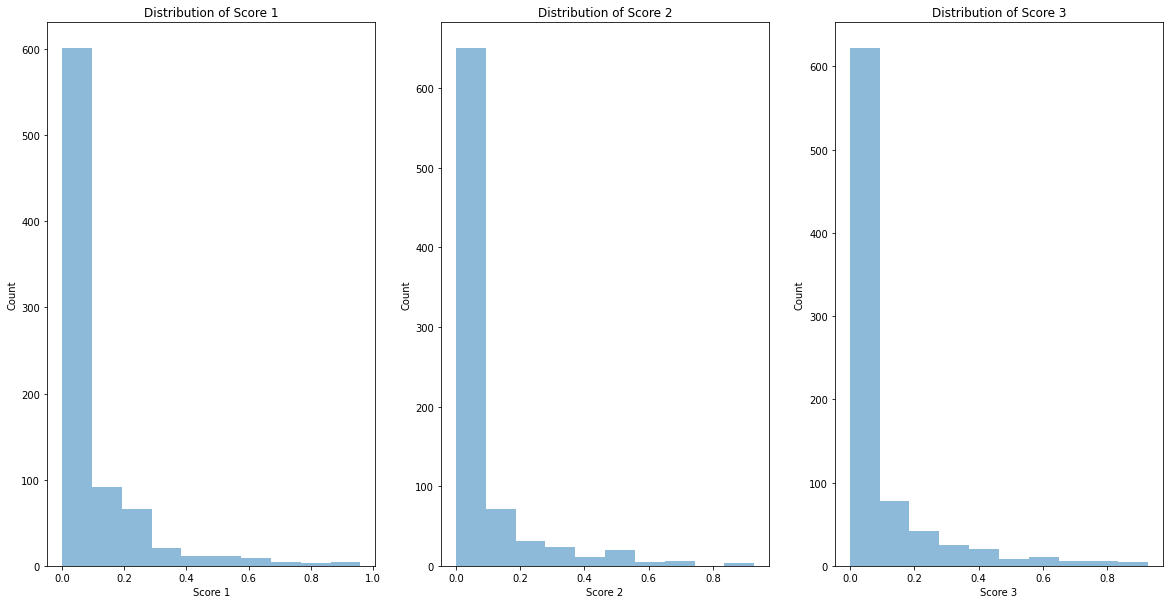

In [8]:
# Intercorrelated
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Separate the sublists into two lists
s1 = list(df_mo_ic['Score 1'])
s2 = list(df_mo_ic['Score 2'])
s3 = list(df_mo_ic['Score 3'])

# Plot the first histogram in the top-left position
axs[0].hist(s1, alpha=0.5)
axs[0].set_title('Distribution of Score 1')
axs[0].set_xlabel('Score 1')
axs[0].set_ylabel('Count')

# Plot the second histogram in the top-right position
axs[1].hist(s2, alpha=0.5)
axs[1].set_title('Distribution of Score 2')
axs[1].set_xlabel('Score 2')
axs[1].set_ylabel('Count')

# Plot the second histogram in the top-right position
axs[2].hist(s3, alpha=0.5)
axs[2].set_title('Distribution of Score 3')
axs[2].set_xlabel('Score 3')
axs[2].set_ylabel('Count')